In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ================= 工具函数 =================

def db(x):
    """安全的 dB 转换"""
    return 10.0 * np.log10(np.maximum(x, 1e-300))

def rect_window(N):
    return np.ones(N)

def hann_window(N):
    # Hann（汉宁）窗：两端为 0，中间为 1
    return np.hanning(N)

def hamming_window(N):
    return np.hamming(N)

def enbw_bins(w):
    """
    ENBW（等效噪声带宽），单位是“DFT 频点间隔个数”（bins）
    ENBW = N * sum(w^2) / (sum(w))^2
    """
    N = len(w)
    num = N * np.sum(w**2)
    den = (np.sum(w))**2
    return float(num / den)

def edge_jump_amplitude(x, w):
    """
    端点跳变（相对 0 的幅度），用于检验“首尾突变”
    - 对 Hann 窗，两端为 0，因此跳变 = 0
    - 对 Hamming 窗，两端约 0.08
    - 对 矩形窗，两端为 1
    """
    xw = x * w
    return float(abs(xw[0])), float(abs(xw[-1]))

def single_sided_modified_periodogram(x, w, fs=1.0):
    """
    单段的“修改周期图”（modified periodogram），单边、窗能量归一、密度刻度
    返回: f(Hz), Pxx
    """
    N = len(x)
    assert len(w) == N
    U = np.sum(w**2)                 # 窗功率用于归一
    X = np.fft.rfft(x * w)
    P = (np.abs(X)**2) / (U * fs)    # 密度刻度（与 Welch 常见实现一致）
    # 单边 2×（除 DC 和 Nyquist）
    if N % 2 == 0:
        P[1:-1] *= 2.0
    else:
        P[1:] *= 2.0
    f = np.fft.rfftfreq(N, d=1.0/fs)
    return f, P

def make_tone(N, k_bin=200, bin_offset=0.25, fs=1.0, phase=0.0):
    """
    生成长度 N 的纯音：
    - bin_offset = 0     -> 恰好落在 DFT 栅格（无本质泄漏）
    - bin_offset != 0    -> 故意偏离栅格，制造泄漏用于对比
    """
    n = np.arange(N)
    f0 = (k_bin + bin_offset) * fs / N
    x = np.sin(2*np.pi*f0*n + phase)
    return x, f0

# ================= 演示/测试 =================

def scenario_A_leakage(N=4096, fs=1.0, k_bin=200, bin_offset=0.25):
    """
    场景 A：非栅格频率（存在泄漏时），比较不同窗的副瓣/泄漏
    """
    x, f0 = make_tone(N, k_bin=k_bin, bin_offset=bin_offset, fs=fs)
    windows = {
        "Rect": rect_window(N),
        "Hann": hann_window(N),
        "Hamming": hamming_window(N),
    }

    plt.figure()
    for name, w in windows.items():
        f, P = single_sided_modified_periodogram(x, w, fs=fs)
        # 归一到峰值 0 dB，便于直观比较副瓣
        Pn = P / np.max(P)
        plt.plot(f, db(Pn), label=name)
    plt.xlim(0, 0.5*fs)
    plt.ylim(-120, 5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB, normalized)")
    plt.title("Scenario A: Off-bin tone (leakage comparison)")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

def scenario_B_mainlobe(N=4096, fs=1.0, k_bin=200):
    """
    场景 B：栅格中心（无本质泄漏），比较主瓣宽度（分辨率代价）
    """
    x, f0 = make_tone(N, k_bin=k_bin, bin_offset=0.0, fs=fs)
    windows = {
        "Rect": rect_window(N),
        "Hann": hann_window(N),
        "Hamming": hamming_window(N),
    }

    plt.figure()
    for name, w in windows.items():
        f, P = single_sided_modified_periodogram(x, w, fs=fs)
        Pn = P / np.max(P)
        plt.plot(f, db(Pn), label=name)
    span = 0.01 * fs
    plt.xlim(f0 - span, f0 + span)
    plt.ylim(-120, 5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB, normalized)")
    plt.title("Scenario B: On-bin tone (mainlobe width)")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

def scenario_C_edge_and_enbw(N_list=(4096, 65536), fs=1.0, k_bin=200, bin_offset=0.25):
    """
    场景 C：不同 N 下的端点跳变与 ENBW 对比
    """
    print("\nScenario C: Edge jump & ENBW")
    print(f"{'N':>8}  {'Window':>8}  {'EdgeLeft':>10}  {'EdgeRight':>10}  {'ENBW(bins)':>12}")
    for N in N_list:
        x, _ = make_tone(N, k_bin=k_bin, bin_offset=bin_offset, fs=fs)
        for name, win_fun in [("Rect", rect_window), ("Hann", hann_window), ("Hamming", hamming_window)]:
            w = win_fun(N)
            lj, rj = edge_jump_amplitude(x, w)
            enbw = enbw_bins(w)
            print(f"{N:8d}  {name:8s}  {lj:10.6f}  {rj:10.6f}  {enbw:12.6f}")

# ================= 入口示例 =================

# 你可以改 N、k_bin、bin_offset 看不同效果
N = 4096
fs = 1.0

# 场景 A：非栅格频率（泄漏对比）
scenario_A_leakage(N=N, fs=fs, k_bin=200, bin_offset=0.25)

# 场景 B：栅格频率（主瓣宽度对比）
scenario_B_mainlobe(N=N, fs=fs, k_bin=200)

# 场景 C：端点跳变与 ENBW（可改不同 N 观察是否“窗很长就没有突变”）
scenario_C_edge_and_enbw(N_list=(4096, 65536), fs=fs, k_bin=200, bin_offset=0.25)


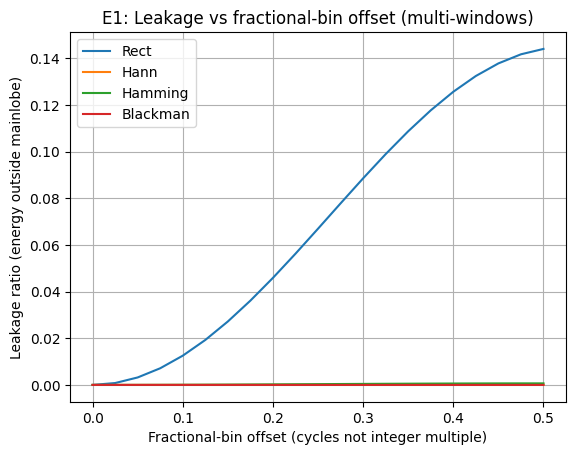

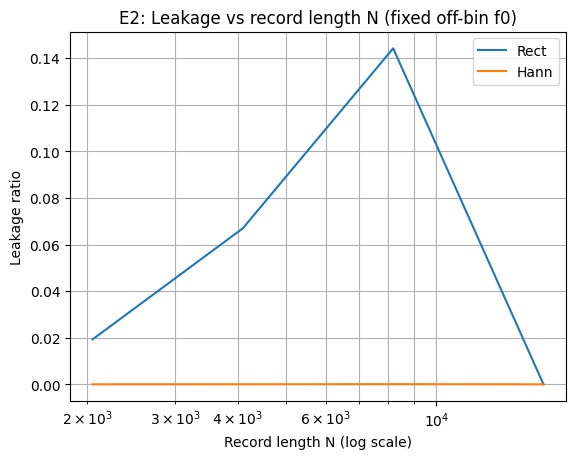

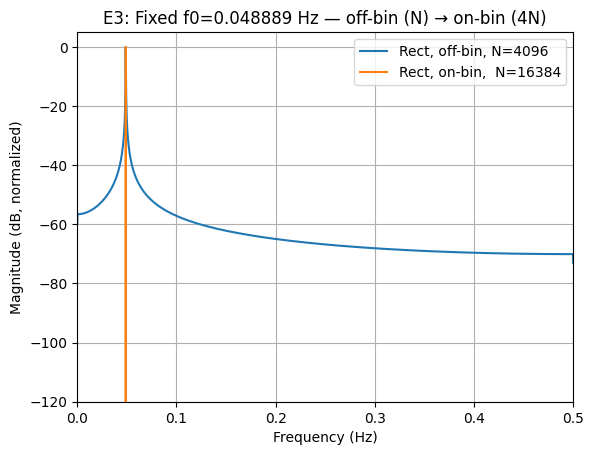

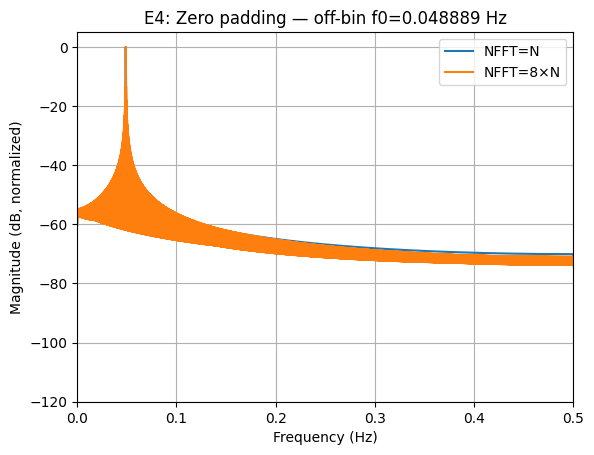

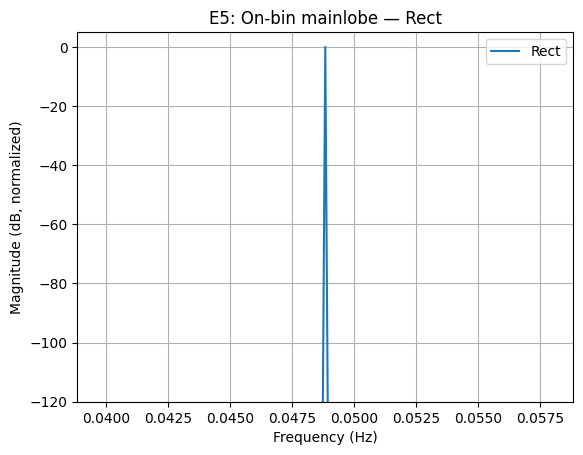

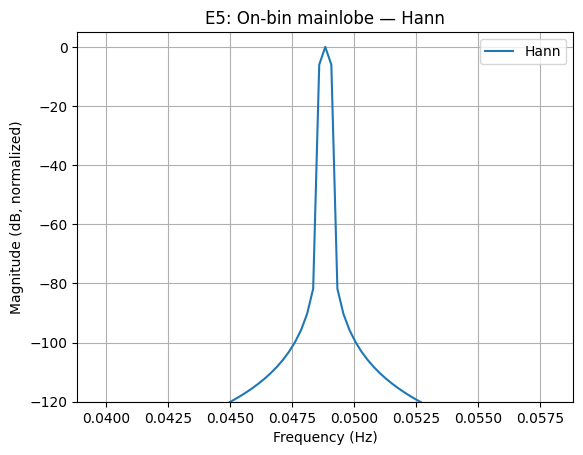

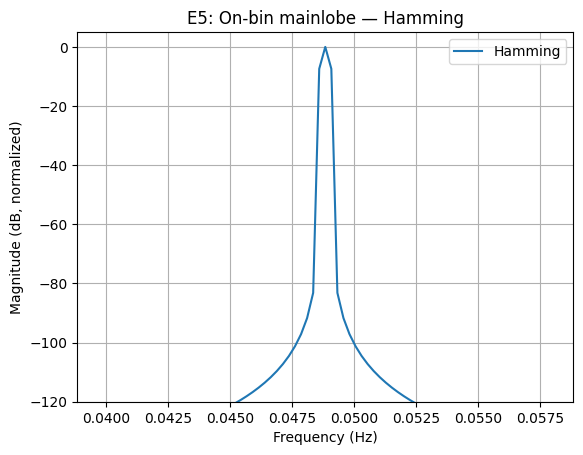

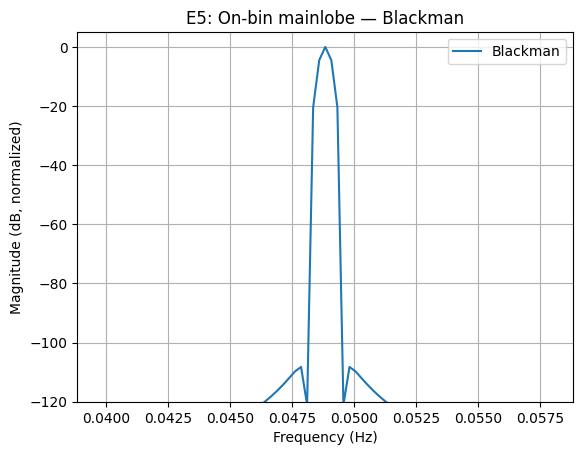


Window        -3 dB width (Hz)   -3 dB (bins)   -6 dB width (Hz)   -6 dB (bins)   ENBW (bins)
---------------------------------------------------------------------------------------------
Rect              4.882812e-04            2        4.882812e-04            2      1.000000
Hann              4.882812e-04            2        4.882812e-04            2      1.500366
Hamming           4.882812e-04            2        4.882812e-04            2      1.363065
Blackman          4.882812e-04            2        9.765625e-04            4      1.727179


In [10]:
# 测试测量信号的间隔为非整数倍周期时，会造成频谱泄漏
# -*- coding: utf-8 -*-
# FFT / 窗函数 / 非整数倍周期导致的频谱泄漏 — 测试集 E1–E5
#
# 依赖：numpy、matplotlib
# 使用：直接运行文件；底部参数可按需修改

import numpy as np
import matplotlib.pyplot as plt


# ========================= 基础工具 =========================

def db(x):
    """功率转 dB，避免 log(0) 溢出"""
    return 10.0 * np.log10(np.maximum(np.asarray(x, dtype=float), 1e-300))

def rect_window(N):
    return np.ones(N)

def hann_window(N):
    # Hann（汉宁）窗：两端 0，中间 1
    return np.hanning(N)

def hamming_window(N):
    return np.hamming(N)

def blackman_window(N):
    return np.blackman(N)

def enbw_bins(w):
    """
    ENBW（等效噪声带宽），单位是“DFT 频点间隔数”（bins）
    ENBW = N * sum(w^2) / (sum(w))^2
    """
    N = len(w)
    w = np.asarray(w, dtype=float)
    return float(N * np.sum(w**2) / (np.sum(w)**2))

def single_sided_modified_periodogram(x, w, fs=1.0):
    """
    单段修改周期图（modified periodogram）
    - 单边谱（rfft）
    - 窗功率归一（除以 sum(w^2)）
    - 密度刻度（再除以 fs）
    返回：f(Hz), Pxx
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    N = len(x)
    assert len(w) == N
    U = np.sum(w**2)
    X = np.fft.rfft(x * w)
    P = (np.abs(X)**2) / (U * fs)

    # 单边 2×（除 DC 和 Nyquist）
    if N % 2 == 0:
        P[1:-1] *= 2.0
    else:
        P[1:] *= 2.0

    f = np.fft.rfftfreq(N, d=1.0/fs)
    return f, P

def single_sided_modified_periodogram_with_nfft(x, w, Nfft, fs=1.0):
    """
    带零填充的修改周期图（改变频率栅格密度，不改变泄漏本质）
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    N = len(x)
    assert len(w) == N and Nfft >= N
    U = np.sum(w**2)
    X = np.fft.rfft(x * w, n=Nfft)
    P = (np.abs(X)**2) / (U * fs)

    if Nfft % 2 == 0:
        P[1:-1] *= 2.0
    else:
        P[1:] *= 2.0

    f = np.fft.rfftfreq(Nfft, d=1.0/fs)
    return f, P

def make_tone(N, k_bin=200, bin_offset=0.25, fs=1.0, phase=0.0):
    """
    生成长度 N 的纯音：
    - bin_offset = 0   → 恰好落在 DFT 栅格（整数倍周期）
    - bin_offset ≠ 0   → 非整数倍周期（频谱泄漏）
    """
    n = np.arange(N)
    f0 = (k_bin + bin_offset) * fs / N
    x = np.sin(2*np.pi*f0*n + phase)
    return x, f0

def make_tone_fixed_freq(N, f0, fs=1.0, phase=0.0):
    n = np.arange(N)
    x = np.sin(2*np.pi*f0*n + phase)
    return x

def leakage_metric(P, main_bins=1):
    """
    粗略“泄漏比例”：主峰附近（±main_bins 个 bin）视为主瓣，其余能量视为泄漏
    返回：泄漏能量 / 总能量
    """
    P = np.asarray(P, dtype=float)
    kmax = int(np.argmax(P))
    lo = max(0, kmax - int(main_bins))
    hi = min(len(P)-1, kmax + int(main_bins))
    main_energy = float(np.sum(P[lo:hi+1]))
    total_energy = float(np.sum(P))
    return max(0.0, 1.0 - main_energy / total_energy)

def mainlobe_width(f, P, thresh_db=-3.0):
    """
    主瓣宽度（简化版）：从峰值向两侧找到首次跌破阈值的点
    返回：(width_hz, width_bins)
    """
    f = np.asarray(f, dtype=float)
    P = np.asarray(P, dtype=float)
    k0 = int(np.argmax(P))
    P0 = P[k0]
    target = P0 * 10.0**(thresh_db/10.0)

    # 左
    kl = k0
    while kl > 0 and P[kl] > target:
        kl -= 1
    # 右
    kr = k0
    while kr < len(P)-1 and P[kr] > target:
        kr += 1

    width_hz = float(abs(f[kr] - f[kl]))
    width_bins = int(kr - kl)
    return width_hz, width_bins


# ========================= 测试场景 E1–E5 =========================

def scenario_E1_offset_sweep_multiwindows(N=4096, fs=1.0, k_bin=200, offsets=None):
    """
    E1：多窗（Rect/Hann/Hamming/Blackman）下，扫分数偏移的泄漏比例
    """
    if offsets is None:
        offsets = np.linspace(0.0, 0.5, 21)

    windows = {
        "Rect": (rect_window(N), 1),
        "Hann": (hann_window(N), 3),
        "Hamming": (hamming_window(N), 3),
        "Blackman": (blackman_window(N), 4),
    }

    curves = {name: [] for name in windows}
    for off in offsets:
        x, _ = make_tone(N, k_bin=k_bin, bin_offset=off, fs=fs)
        for name, (w, main_bins) in windows.items():
            _, P = single_sided_modified_periodogram(x, w, fs=fs)
            leak = leakage_metric(P, main_bins=main_bins)
            curves[name].append(leak)

    plt.figure()
    for name in windows.keys():
        plt.plot(offsets, curves[name], label=name)
    plt.xlabel("Fractional-bin offset (cycles not integer multiple)")
    plt.ylabel("Leakage ratio (energy outside mainlobe)")
    plt.title("E1: Leakage vs fractional-bin offset (multi-windows)")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()


def scenario_E2_length_sweep(f0_off, N_list=(2048, 4096, 8192, 16384), fs=1.0,
                             plot_each_spectrum=False):
    """
    E2：固定 off-bin 频率，改变记录长度 N，观察泄漏（矩形窗 & Hann）
    """
    results = {"Rect": [], "Hann": []}
    for N in N_list:
        x = make_tone_fixed_freq(N, f0_off, fs=fs)
        for name, (wfun, main_bins) in {
            "Rect": (rect_window, 1),
            "Hann": (hann_window, 3),
        }.items():
            w = wfun(N)
            f, P = single_sided_modified_periodogram(x, w, fs=fs)
            leak = leakage_metric(P, main_bins=main_bins)
            results[name].append((N, leak))

            if plot_each_spectrum:
                plt.figure()
                plt.plot(f, db(P/np.max(P)), label=f"{name}, N={N}")
                plt.xlim(0, 0.5*fs)
                plt.ylim(-120, 5)
                plt.xlabel("Frequency (Hz)")
                plt.ylabel("Magnitude (dB, normalized)")
                plt.title(f"E2: Spectrum at off-bin f0={f0_off:.6f} Hz")
                plt.grid(True, which="both")
                plt.legend()
                plt.show()

    plt.figure()
    for name in results:
        Ns = [t[0] for t in results[name]]
        Ls = [t[1] for t in results[name]]
        plt.plot(Ns, Ls, label=name)
    plt.xscale("log")
    plt.xlabel("Record length N (log scale)")
    plt.ylabel("Leakage ratio")
    plt.title("E2: Leakage vs record length N (fixed off-bin f0)")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()


def scenario_E3_make_integer_cycles(N0=4096, k_bin=200, off=0.25, fs=1.0):
    """
    E3：固定 f0（按 N0 定义 off-bin），把 N 从 N0 变为 4N0，使 off-bin → on-bin
    """
    f0_off = (k_bin + off) * fs / N0
    N1 = 4 * N0  # 因为 off=1/4，乘 4 变整数

    x0 = make_tone_fixed_freq(N0, f0_off, fs=fs)
    x1 = make_tone_fixed_freq(N1, f0_off, fs=fs)

    f0s, P0 = single_sided_modified_periodogram(x0, rect_window(N0), fs=fs)
    f1s, P1 = single_sided_modified_periodogram(x1, rect_window(N1), fs=fs)

    plt.figure()
    plt.plot(f0s, db(P0/np.max(P0)), label=f"Rect, off-bin, N={N0}")
    plt.plot(f1s, db(P1/np.max(P1)), label=f"Rect, on-bin,  N={N1}")
    plt.xlim(0, 0.5*fs)
    plt.ylim(-120, 5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB, normalized)")
    plt.title(f"E3: Fixed f0={f0_off:.6f} Hz — off-bin (N) → on-bin (4N)")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()


def scenario_E4_zero_padding(N=4096, k_bin=200, off=0.25, fs=1.0, zp=8):
    """
    E4：零填充（NFFT 放大）对比：泄漏形状不变，只是频率采样更密
    """
    x, f0_off = make_tone(N, k_bin=k_bin, bin_offset=off, fs=fs)
    w = rect_window(N)

    f1, P1 = single_sided_modified_periodogram(x, w, fs=fs)
    f2, P2 = single_sided_modified_periodogram_with_nfft(x, w, Nfft=zp*N, fs=fs)

    plt.figure()
    plt.plot(f1, db(P1/np.max(P1)), label=f"NFFT=N")
    plt.plot(f2, db(P2/np.max(P2)), label=f"NFFT={zp}×N")
    plt.xlim(0, 0.5*fs)
    plt.ylim(-120, 5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB, normalized)")
    plt.title(f"E4: Zero padding — off-bin f0={f0_off:.6f} Hz")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()


def scenario_E5_mainlobe_width_table(N=4096, fs=1.0, k_bin=200, show_plots=True):
    """
    E5：主瓣宽度（on-bin）与 ENBW 表
    - 计算 Rect/Hann/Hamming/Blackman 的 -3 dB 与 -6 dB 宽度（Hz & bins）以及 ENBW
    """
    x, f0 = make_tone(N, k_bin=k_bin, bin_offset=0.0, fs=fs)
    wins = {
        "Rect": rect_window(N),
        "Hann": hann_window(N),
        "Hamming": hamming_window(N),
        "Blackman": blackman_window(N),
    }

    rows = []
    for name, w in wins.items():
        f, P = single_sided_modified_periodogram(x, w, fs=fs)
        w3_hz, w3_bins = mainlobe_width(f, P, -3.0)
        w6_hz, w6_bins = mainlobe_width(f, P, -6.0)
        rows.append((name, w3_hz, w3_bins, w6_hz, w6_bins, enbw_bins(w)))

        if show_plots:
            plt.figure()
            Pn = P/np.max(P)
            span = 0.01 * fs
            plt.plot(f, db(Pn), label=name)
            plt.xlim(f0 - span, f0 + span)
            plt.ylim(-120, 5)
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Magnitude (dB, normalized)")
            plt.title(f"E5: On-bin mainlobe — {name}")
            plt.grid(True, which="both")
            plt.legend()
            plt.show()

    # 打印表格
    header = (
        "Window        -3 dB width (Hz)   -3 dB (bins)   "
        "-6 dB width (Hz)   -6 dB (bins)   ENBW (bins)"
    )
    print("\n" + header)
    print("-"*len(header))
    for name, w3_hz, w3_bins, w6_hz, w6_bins, enbw in rows:
        print(f"{name:<12s} {w3_hz:>17.6e} {w3_bins:>12d}   "
              f"{w6_hz:>17.6e} {w6_bins:>12d}   {enbw:>11.6f}")


# ========================= 入口参数 & 运行 =========================

if __name__ == "__main__":
    # 你可以自由修改下面这些参数
    N    = 4096     # 记录长度
    fs   = 1.0      # 采样频率（只影响频率轴刻度）
    kbin = 200      # 目标基准 bin
    off  = 0.25     # 分数 bin 偏移（非整数倍周期常用 0.25）

    # E1：不同窗的泄漏-偏移曲线
    scenario_E1_offset_sweep_multiwindows(N=N, fs=fs, k_bin=kbin)

    # E2：固定频率 f0（off-bin），改变 N 看泄漏（可开启逐谱图像）
    f0_off = (kbin + off) * fs / N
    scenario_E2_length_sweep(f0_off, N_list=(2048, 4096, 8192, 16384), fs=fs, plot_each_spectrum=False)

    # E3：把 N 扩展为 4N，使 off=1/4 的频率恰好变整数倍周期
    scenario_E3_make_integer_cycles(N0=N, k_bin=kbin, off=off, fs=fs)

    # E4：零填充（更细的频率采样），泄漏形状不变
    scenario_E4_zero_padding(N=N, k_bin=kbin, off=off, fs=fs, zp=8)

    # E5：主瓣宽度 & ENBW（on-bin），并打印对比表
    scenario_E5_mainlobe_width_table(N=N, fs=fs, k_bin=kbin, show_plots=True)
